In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
 import tensorflow as tf
 import numpy as np
 import matplotlib.pyplot as plt
 import pandas as pd


In [3]:
import os

In [4]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Dropout,Flatten
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator



In [5]:
#fetching images from folders:
count=0
dirs=os.listdir('/content/drive/MyDrive/flowers/images')
for dir in dirs:
  files=list(os.listdir('/content/drive/MyDrive/flowers/images/'+dir))
  count=count+1
  print(dir+'Folder has '+str(len(files))+' images')
print('images folder has '+str(count)+' images')

tulipFolder has 831 images
roseFolder has 671 images
daisyFolder has 669 images
dandelionFolder has 927 images
sunflowerFolder has 644 images
images folder has 5 images


In [6]:
#load images into arrays as dataset
base_dir='/content/drive/MyDrive/flowers/images/'
img_size=180
batch=32


In [52]:
train_ds=tf.keras.utils.image_dataset_from_directory(base_dir,seed=123,validation_split=0.2,subset='training',image_size=(img_size,img_size),batch_size=batch)
val_ds=tf.keras.utils.image_dataset_from_directory(base_dir,seed=123,validation_split=0.2,subset='validation',image_size=(img_size,img_size),batch_size=batch)

Found 3742 files belonging to 5 classes.
Using 2994 files for training.
Found 3742 files belonging to 5 classes.
Using 748 files for validation.


In [53]:
flower_names=train_ds.class_names
print(flower_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


## .take(n) is a method of the tf.data.Dataset class. It creates a new dataset that contains only the first n elements from the original dataset.
In this case, .take(1) means that you are only taking the first batch of data from train_ds.

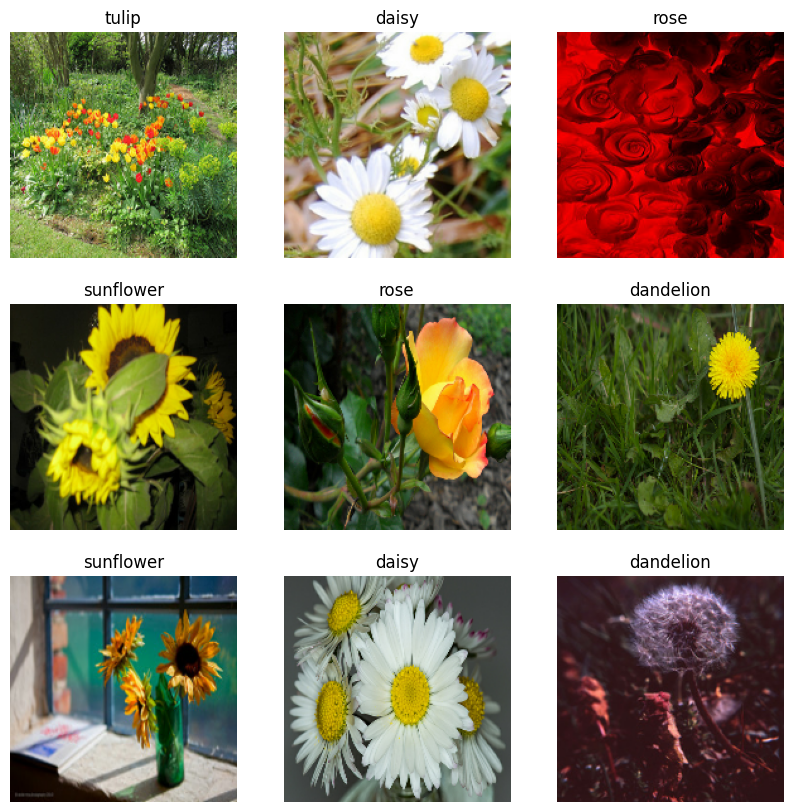

In [9]:
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(flower_names[labels[i]])
    plt.axis('off')


## i+1: Since subplot indexing typically starts from 1 (not 0), i+1 ensures that the subplots are numbered sequentially from 1 to 9 as the loop iterates.
* **.numpy():** This method is used to convert a TensorFlow tensor (if images[i] is a tensor) to a NumPy array. NumPy arrays are commonly used for numerical operations and image processing in Python.

* **.astype('uint8'): This converts the data type of the image array to uint8.** This is a common data type for images, representing 8-bit unsigned integers (values from 0 to 255), which correspond to pixel intensities.

* **plt.imshow(): This is a Matplotlib function used to display an image.** It takes an image array as input and displays it in the current subplot (which was likely set using plt.subplot before this line).

In [10]:
AUTOTUNE=tf.data.AUTOTUNE
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)

* **ta.AUTOTUNE:** This sets AUTOTUNE to a special value provided by TensorFlow. It allows TensorFlow to dynamically tune the buffer sizes for various operations like prefetching and shuffling based on the available resources.

* **cache():** This method caches the dataset in memory. It's particularly useful when you're going to iterate over the dataset multiple times (e.g., during multiple training epochs). By caching the data, you avoid the overhead of reloading and preprocessing it each time.


* **shuffle(1000):** This shuffles the training dataset with a buffer size of 1000. Shuffling is important to randomize the order of training samples, which helps improve the generalization ability of the model. The buffer size determines how many elements are shuffled at a time.


* **prefetch(buffer_size=AUTOTUNE):** This prefetches data in the background while the model is training. This ensures that the model doesn't have to wait for data loading, reducing training time. Using AUTOTUNE lets TensorFlow dynamically adjust the buffer size for optimal performance.


> AUTOTUNE itself is not a function, but rather a constant provided by the tf.data module. It acts as a placeholder value that signals to TensorFlow to dynamically determine the optimal parameter for certain operations within the data pipeline.


Think of it as telling TensorFlow: "Hey, I don't know the best value for this buffer size or parallel calls, you figure it out based on the system and my data."


TensorFlow then uses its internal heuristics and performance models to find the best value at runtime.

In [11]:
# data augmentation:


> Data augmentation is a technique used to artificially increase the size and diversity of a dataset by creating modified copies of existing data or synthesizing new data points based on existing ones. It's a valuable tool in machine learning, particularly in computer vision, natural language processing, and speech recognition.

//

Here's a simple analogy:


Imagine you're teaching a child to recognize different breeds of dogs. You have a limited number of dog pictures. Data augmentation is like showing the child the same pictures from different angles, zoomed in or out, flipped horizontally, or with slightly altered lighting. This helps the child learn to recognize dogs even if they look slightly different from the original pictures.

In [12]:
data_augmentation=Sequential([
  layers.RandomFlip('horizontal',input_shape=(img_size,img_size,3)),
  # 3 means RGB values
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


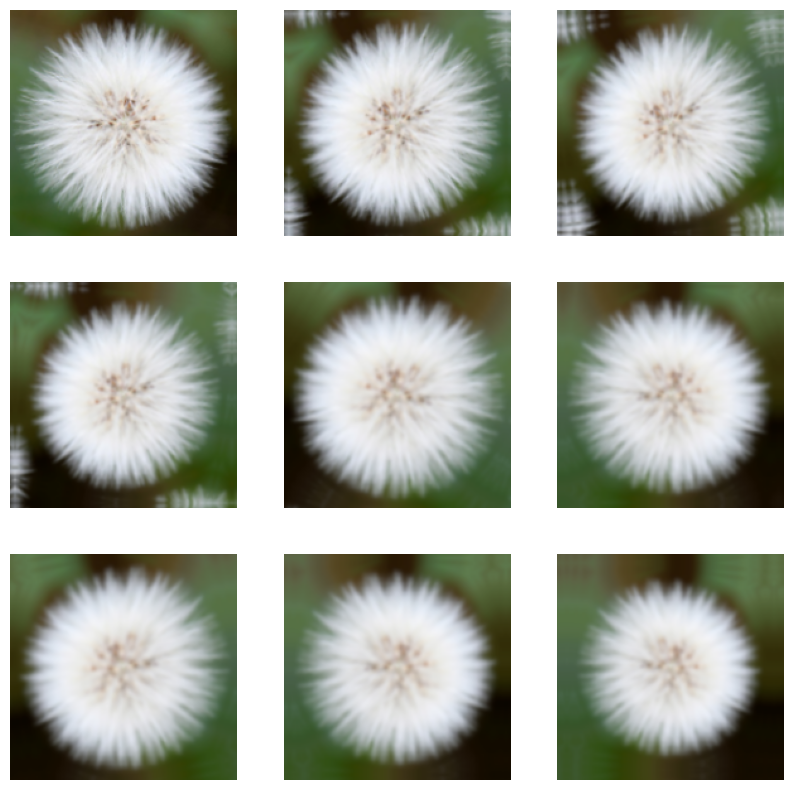

In [13]:
i=0
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for i in range(9):
    images=data_augmentation(images)
    plt.subplot(3,3,i+1)
    plt.imshow(images[0].numpy().astype('uint8'))
    plt.axis('off')

* **layers.Rescaling(1./255) :** This layer rescales the pixel values of the input images. By dividing each pixel value by 255, you normalize the values to be between 0 and 1. This is a common preprocessing step that can improve model performance.

* **Conv2D(16, 3, padding='same', activation='relu') :** This is a 2D convolutional layer, a fundamental building block of convolutional neural networks (CNNs).

* **16 :** The number of filters (or kernels) in the layer. Filters extract different features from the input image.

* **3 :** The kernel size, specifying the dimensions of the filters (3x3 in this case).
padding='same': Ensures that the output feature maps have the same dimensions as the input.
activation='relu': Applies the ReLU (Rectified Linear Unit) activation function to the output of the convolution, introducing non-linearity into the model.
* **MaxPool2D():** This is a max pooling layer, which downsamples the feature maps produced by the convolutional layer. It helps reduce the dimensionality of the data and make the model more robust to small variations in the input.

In summary, this model takes an image as input, applies data augmentation, rescales the pixel values, performs a convolution to extract features, and then downsamples the features using max pooling. This is a common pattern in the early stages of CNNs for image-related tasks.

In [14]:
#model creation:

In [15]:
model=Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(16,3,padding='same',activation='relu'),
    MaxPool2D(),
    Conv2D(32,3,padding='same',activation='relu'),
    MaxPool2D(),
    Conv2D(64,3,padding='same',activation='relu'),
    MaxPool2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(5)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

* **model.compile(...):** This is a Keras function used to configure the learning process of the model. You specify the optimizer, loss function, and metrics to be used during training.

//

* **optimizer='adam':** The optimizer determines how the model's weights are updated during training based on the calculated gradients. Adam is a popular optimization algorithm that adapts the learning rate for each parameter, often leading to faster convergence and better results.

//

* **loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True):** The loss function measures the difference between the model's predictions and the true labels. SparseCategoricalCrossentropy is commonly used for multi-class classification problems where the labels are integers representing the class indices (e.g., 0 for class 1, 1 for class 2, etc.).

//

* **from_logits=True** indicates that the output of your model does not have a softmax activation applied. The softmax function converts model outputs into probabilities, which are required for SparseCategoricalCrossentropy to work correctly. If your model's last layer doesn't have a softmax activation, you should set from_logits=True.
* **metrics=['accuracy']:** Metrics are used to evaluate the model's performance during training and testing. Accuracy is a common metric for classification, measuring the percentage of correctly classified samples.

//

Let's say your model outputs the following logits for a 3-class classification problem: [2.0, 1.0, 0.1].

*The softmax function would transform these logits into probabilities* like this:

[0.7, 0.2, 0.1] (approximately)
These probabilities indicate that the input is most likely to belong to class 1 (70% probability), followed by class 2 (20%), and then class 3 (10%).



> In essence, the **softmax activation function** is a crucial component in neural networks for converting raw model outputs into meaningful probabilities for multi-class classification tasks.

> **Logits** are the raw output values produced by a neural network layer, typically the layer before the softmax activation function in a classification model. They represent the unnormalized scores or activations for each class.



//


> **Accuracy generally increases as the number of epochs increases because the model has more opportunities to learn the patterns in the data.**

Here's a breakdown of why this happens:

* **Optimization:** During each epoch, the model processes the entire training dataset and adjusts its internal parameters (weights and biases) to minimize the difference between its predictions and the true labels. This process is called optimization.

* **Gradient descent:** Most deep learning models use an optimization algorithm called gradient descent. This algorithm iteratively updates the model's parameters based on the gradients (direction and magnitude of error) calculated during training.

* **Iterative learning:** With more epochs, the model goes through more iterations of gradient descent, gradually refining its parameters to better fit the training data.
Finding optimal parameters: The goal is to find a set of parameters that allows the model to make accurate predictions on both the training data and unseen data. This often requires many iterations (epochs) of training.

  *However, there are some caveats:*

* **Overfitting:** If you train for too many epochs, the model might start to overfit the training data. This means it becomes too specialized in the training data and performs poorly on new, unseen data.
* **Diminishing returns:** At some point, increasing the number of epochs might lead to diminishing returns. The accuracy might plateau or even start decreasing due to overfitting.
* **Computational cost:** More epochs mean longer training times, which can be a significant factor, especially with large datasets and complex models.

In [18]:
history=model.fit(train_ds,epochs=15,validation_data=val_ds)

Epoch 1/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.3440 - loss: 1.5208 - val_accuracy: 0.5107 - val_loss: 1.1319
Epoch 2/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.5872 - loss: 1.0450 - val_accuracy: 0.5922 - val_loss: 1.0466
Epoch 3/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.6311 - loss: 0.9427 - val_accuracy: 0.6324 - val_loss: 0.9364
Epoch 4/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.6434 - loss: 0.9072 - val_accuracy: 0.6618 - val_loss: 0.8819
Epoch 5/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.6737 - loss: 0.8456 - val_accuracy: 0.6604 - val_loss: 0.8922
Epoch 6/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.6923 - loss: 0.8027 - val_accuracy: 0.6791 - val_loss: 0.8625
Epoch 7/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7046 - loss: 0.7619 - val_accuracy: 0.6898 - val_loss: 0.7960
Epoch 8/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.7056 - loss: 0.7563 - val_accuracy: 0.7019 - v


* **model.fit(...):** This is the core function in Keras for training a model. You provide the training data, the number of training epochs, and optional validation data.

* **train_ds:** This is your training dataset, which you've presumably defined and preprocessed earlier. It contains the input data (e.g., images) and corresponding labels.

* **epochs=15:** Epochs determine how many times the model will iterate over the entire training dataset.
 * *In this case, the model will be trained for 15 epochs, meaning it will see and learn from the entire training data 15 times.*


* **validation_data=val_ds:** This is your validation dataset, which is used to evaluate the model's performance on data it hasn't seen during training. This helps monitor for overfitting (when the model performs well on training data but poorly on unseen data).

* **history = ...:** The fit function returns a History
object that contains information about the training process, such as the loss and metrics values for each epoch on both the training and validation sets. This information can be used to analyze the training progress and plot learning curves.

In simpler terms:

>Imagine you're teaching a dog a new trick.

>model.fit is like the actual training session.

> train_ds is the set of instructions and examples you show the dog.

> epochs are the number of practice repetitions you do.
validation_data is like occasionally testing the dog with a slightly different scenario to see if it has truly learned the trick.

> history is your training log, where you note down the dog's progress and any mistakes it made.

>By calling model.fit, you're essentially starting the process of teaching your model to learn from the data and make accurate predictions. The History object provides valuable insights into how the model is learning and performing over time.


In [31]:
for layer in model.layers:
  if 'flatten' in layer.name:
    flatten_layer = layer
    break

# Define target_size with a default value.
# This assumes your input images are 28x28 pixels.
# Adjust this if your input images have a different size.
target_size = (28, 28)

# Call the layer on some input to get the output shape
output_shape = flatten_layer(tf.zeros((1, *target_size))).shape

# Access the correct indices of output_shape
target_size = (output_shape[0], output_shape[1])


print(f'Target size: {target_size}')

Target size: (1, 784)


In [47]:
def classify_images(image_path):
  input_image=tf.keras.utils.load_img(image_path,target_size=(180, 180))
  input_image_arr=tf.keras.utils.img_to_array(input_image)

  input_image_exp=tf.expand_dims(input_image_arr,0)

  predictions=model.predict(input_image_exp)
  result=tf.nn.softmax(predictions[0])
  outcome='The image is classified as '+flower_names[np.argmax(result)]  +' with  a score of '+str(np.max(result)*100)
  return outcome




In [48]:
classify_images('/content/drive/MyDrive/flowers/sample/daisy/daisy_sample.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


'The image is classified as daisy with  a score of 42.506143450737'

In [51]:
# Save the model architecture and weights only
model.save('Flower_Recognition_model.keras')

In [ ]:
#to access: model = tf.keras.models.load_model('Flower_Recognition_model.keras')
